# Code Setup

In [24]:
#import libraries
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts, cross_val_score as cvs
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

#hide warnings
import warnings
warnings.filterwarnings(action = 'ignore', category = FutureWarning)
warnings.filterwarnings(action = 'ignore', category = DeprecationWarning)

In [2]:
#import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#define input and output variables from training data

random_seed = 1234

X = train.drop('label', axis = 1)
y = train['label']

In [4]:
#build some functions

def fit_model(model,X,y):
    start = timer()
    model.fit(X,y)
    end = timer()
    print('Seconds to fit model: {:.3f}'.format(end-start))
    
def prediction(model, X, filename):
    pred = model.predict(X)
    imageid = [int(i) for i in range(1,len(pred)+1)]
    file = pd.DataFrame({'ImageID': imageid,
                        'Label': pred})
    file.to_csv(filename)

# Random Forest on all variables

In [5]:
#using hyperparameters laid out in the assignment description
allvar = RandomForestClassifier(n_estimators = 10, bootstrap = True, max_features = 'sqrt',random_state = random_seed)

fit_model(allvar, X, y)

Seconds to fit model: 3.808


In [6]:
prediction(allvar, test, 'All_Variable_Prediction.csv')

# Principal Component Analysis

In [7]:
#PCA model, first need to combine training and test sets to look at all variables
#using X variable that was originally created and does not have label column

all_data = X.append(test)

#combined records should be the sum of the first two
print('Train + Test records:', len(X) + len(test))
print('Combined records:', len(all_data))

Train + Test records: 70000
Combined records: 70000


In [8]:
#find components for 95% of the variance

start = timer()
pca = PCA(n_components = 0.95)
X_reduc = pca.fit_transform(all_data)
end = timer()
print('Seconds to fit model: {:.3f}'.format(end-start))

Seconds to fit model: 10.726


In [9]:
#find best components from PCA
pca_best = pca.n_components_
pca = PCA(n_components = pca_best)

start = timer()
pca_train = pca.fit_transform(train)
end = timer()
print('Seconds to fit model: {:.3f}'.format(end-start))



Seconds to fit model: 5.726


In [10]:
#how many features are included in 95% of the variance?
pca_best

154

In [11]:
#fit model for training data using dimension reduction
rf_pca = RandomForestClassifier(n_estimators = 10, bootstrap = True, max_features = 'sqrt',random_state = random_seed)

fit_model(rf_pca,pca_train,y)

Seconds to fit model: 9.508


In [12]:
#predict outputs using dimension reduction

pca_test = pca.fit_transform(test)

prediction(rf_pca, pca_test, 'Reduced_Variable_Predictions.csv')

# Quick comparison to see how many different results I got between the outputs

In [13]:
#both outputed csv files for Kaggle upload
full = pd.read_csv('All_Variable_Prediction.csv')
reduced = pd.read_csv('Reduced_Variable_Predictions.csv')
reduced = reduced.rename(columns = {'Label': 'Label2'})

In [14]:
#1 df for side by side comparison
comp = pd.concat([full, reduced['Label2']], axis = 1)

In [15]:
print('Total Record Count:',len(comp))
print('Different Record Count:',len(comp[comp['Label'] != comp['Label2']]) )

Total Record Count: 28000
Different Record Count: 17784


# Updated Model after Fixing Issue

To do's for this part:
-fit model using training and testing sets, all from train data source
-scale data using normal scaler
-optimize random forest to improve model based on testing performance

In [8]:
#Split training data into train and test sets
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.2, random_state = random_seed)

In [14]:
#using pipeline to fit the model for both PCA and random forest
#using only training data here

pipe = Pipeline([('pca', PCA(n_components = 0.95)),
                ('rf', RandomForestClassifier(bootstrap = True, max_features = 'sqrt',random_state = random_seed))])

#pipe.fit(X_train, y_train)
fit_model(pipe, X_train, y_train)

Seconds to fit model: 17.105


In [16]:
print('Training score: {:.3f}'.format(pipe.score(X_train, y_train)))
print('Test score: {:.3f}'.format(pipe.score(X_test, y_test)))

Training score: 0.999
Test score: 0.866


In [27]:
#check for cross validation results and accuracy score

print(cvs(pipe, X_train, y_train, cv = 5, scoring = 'accuracy'))

y_pred = pipe.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)

[0.85782272 0.86492115 0.8688793  0.86826436 0.86199196]


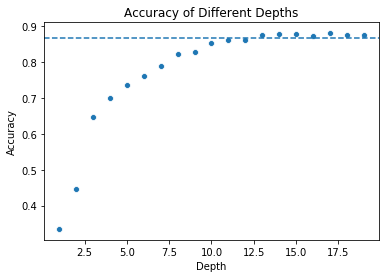

In [30]:
#model is overfitting, what do the different depths look like for accuracy?
depth = []
accuracy = []
for i in range(1,20):
    tree = Pipeline([('pca', PCA(n_components = 0.95)),
                ('rf', RandomForestClassifier(max_depth = i, bootstrap = True, max_features = 'sqrt',
                                              random_state = random_seed))])
    tree.fit(X_train, y_train)
    ypred = tree.predict(X_test)
    score = accuracy_score(y_test, ypred)
    accuracy.append(score)
    depth.append(i)

sns.scatterplot(x = depth, y = accuracy)
plt.axhline(y=acc_score, ls='--')
#plt.axhline(y=acc_score, xmin=0, xmax=11, ls='--')
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.title('Accuracy of Different Depths')
plt.show()

# Build final model with all adjustments made

In [31]:
#refit model with better max depth
#use entire training dataset provided by Kaggle

pipe = Pipeline([('pca', PCA(n_components = 0.95)),
                ('rf', RandomForestClassifier(n_estimators = 100, max_depth = 17, bootstrap = True, max_features = 'sqrt',
                                              random_state = random_seed))])

fit_model(pipe, X, y)

Seconds to fit model: 97.508


In [32]:
#build final prediction
prediction(pipe, test, 'Final_MNIST_Predictions.csv')

In [33]:
#first and last outputed csv files for Kaggle upload
#compare how many predictions are different

full = pd.read_csv('All_Variable_Prediction.csv')
final = pd.read_csv('Final_MNIST_Predictions.csv')
final = final.rename(columns = {'Label': 'Label2'})

#1 df for side by side comparison
comp = pd.concat([full, final['Label2']], axis = 1)

print('Total Record Count:',len(comp))
print('Different Record Count:',len(comp[comp['Label'] != comp['Label2']]) )

Total Record Count: 28000
Different Record Count: 1829
